In [124]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve

import seaborn as sns
import matplotlib.pyplot as plt

import datetime as dt
from datetime import datetime

import statsmodels.api as sm
import statsmodels.formula.api as smf

from pandasql import sqldf

In [125]:
df = pd.read_csv('data.csv')

In [126]:
x = df[['country', 'year', 'uniqueid', 'location_type',
       'cellphone_access', 'household_size', 'age_of_respondent',
       'gender_of_respondent', 'relationship_with_head', 'marital_status',
       'education_level', 'job_type']]


y = df[['bank_account']]

x_tr, x_test, y_tr, y_test = train_test_split(x, y,test_size=.25, random_state=12)

In [127]:
x_tr['is_urban'] = np.where(x_tr['location_type'] == 'Urban',1,0)
x_tr['cellphone'] = np.where(x_tr['cellphone_access'] == 'Yes',1,0)
x_tr['is_male'] = np.where(x_tr['gender_of_respondent'] == 'Male',1,0)

<ipython-input-127-02e3f9e08314>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_tr['is_urban'] = np.where(x_tr['location_type'] == 'Urban',1,0)
<ipython-input-127-02e3f9e08314>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_tr['cellphone'] = np.where(x_tr['cellphone_access'] == 'Yes',1,0)
<ipython-input-127-02e3f9e08314>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

In [128]:
x_tr_cont = x_tr[['year','household_size','age_of_respondent','is_urban','cellphone','is_male']]
x_tr_cat = x_tr[['country','relationship_with_head', 'marital_status','education_level', 'job_type']]

In [129]:
# Regroup to reduce number of categories
x_tr_cat.loc[x_tr_cat['marital_status'] == 'Dont know', ['marital_status']] = 'Single/Never Married'
x_tr_cat.loc[x_tr_cat['education_level'] == 'Other/Dont know/RTA', ['education_level']] = 'No formal education'
x_tr_cat.loc[x_tr_cat['job_type'] == 'Dont Know/Refuse to answer', ['job_type']] = 'No Income'
x_tr_cat.loc[x_tr_cat['relationship_with_head'] == 'Other non-relatives', ['relationship_with_head']] = 'Other relative'

/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-129-fd79ac22a8b3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_tr_cat.loc[x_tr_cat['marital_status'] == 'Dont know', ['marital_status']] = 'Single/Never Married'
<ipython-input-129-fd79ac22a8b3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a

In [130]:
ohe = OneHotEncoder(drop='first', sparse=False)

ohe.fit(x_tr_cat)

ohe_x_train = ohe.transform(x_tr_cat)

columns = ohe.get_feature_names(['county','relationship_with_head', 'marital_status',
       'education_level', 'job_type'])

ohe_x_tr_df = pd.DataFrame(ohe_x_train, columns=columns, index=x_tr.index)

In [131]:
combo_train_df = pd.concat([x_tr_cont, ohe_x_tr_df], axis=1)

In [132]:
combo_train_df.columns

Index(['year', 'household_size', 'age_of_respondent', 'is_urban', 'cellphone',
       'is_male', 'county_Rwanda', 'county_Tanzania', 'county_Uganda',
       'relationship_with_head_Head of Household',
       'relationship_with_head_Other relative',
       'relationship_with_head_Parent', 'relationship_with_head_Spouse',
       'marital_status_Married/Living together',
       'marital_status_Single/Never Married', 'marital_status_Widowed',
       'education_level_Primary education',
       'education_level_Secondary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_Informally employed', 'job_type_No Income',
       'job_type_Other Income', 'job_type_Remittance Dependent',
       'job_type_Self employed'],
      dtype='object')

In [133]:
combo_train_df['marital_status_Single/Never Married'].sum()

6075.0

In [134]:
# Create dummy variable for bank account
y_tr['bank_acc'] = np.where(y_tr['bank_account'] == 'Yes', 1,0)

<ipython-input-134-b1430f2c33c5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_tr['bank_acc'] = np.where(y_tr['bank_account'] == 'Yes', 1,0)


In [135]:
x_train, x_val, y_train, y_val = train_test_split(combo_train_df, y_tr, test_size=.20, random_state=11)

In [136]:
y_train.drop(columns='bank_account',inplace=True)
y_val.drop(columns='bank_account',inplace=True)

/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


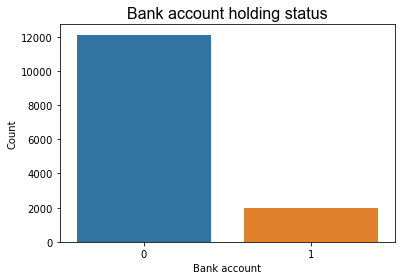

In [137]:
sns.countplot(x='bank_acc', data=y_train)
plt.title('Bank account holding status',family='arial',fontsize=16)
plt.xlabel('Bank account')
plt.ylabel('Count')
plt.show;

In [138]:
count_no_acc = len(y_train[y_train['bank_acc']==0])
count_acc = len(y_train[y_train['bank_acc']==1])
pct_of_no_acc = count_no_acc/(count_no_acc+count_acc)
print("percentage of no account:", pct_of_no_acc*100)
pct_of_acc = count_acc/(count_no_acc+count_acc)
print("percentage of account", pct_of_acc*100)

percentage of no account: 85.9288649567805
percentage of account 14.071135043219499


Classes are __very imbalanced__ - how to deal with this?

In [139]:
df_train = pd.concat([x_train,y_train],axis=1)
df_val = pd.concat([x_val,y_val],axis=1)

In [140]:
# Create dateframes to use for visualisations
df_vis_cont = pd.concat([x_tr_cont,y_tr],axis=1)
df_vis_cat = pd.concat([ohe_x_tr_df,y_tr],axis=1)

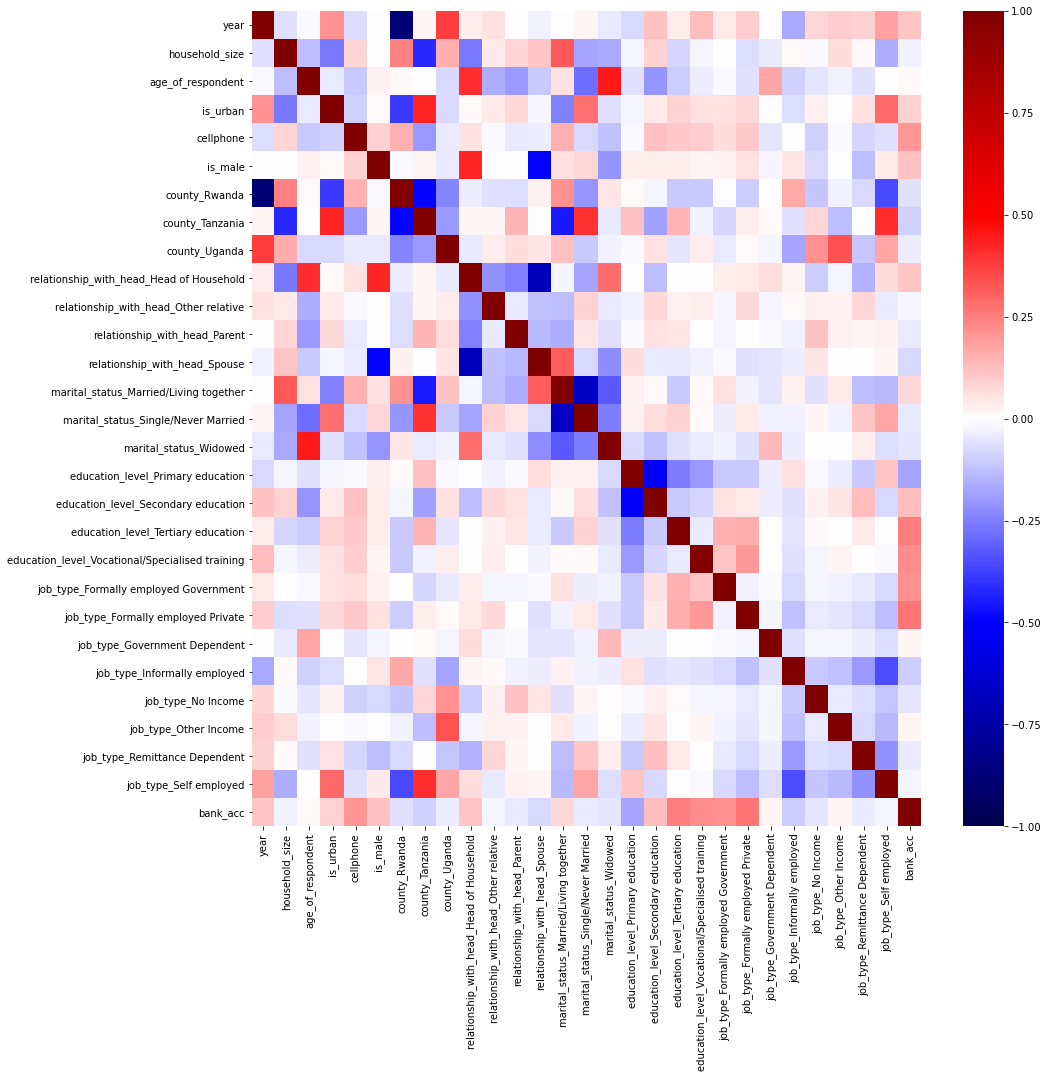

In [141]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(df_train.corr(), cmap="seismic", vmin=-1, vmax=1, ax=ax);

In [142]:
#fig, ax = plt.subplots(figsize=(15, 15))
#pd.plotting.scatter_matrix(df_vis_cont[df_vis_cont.columns[0:]], ax=ax);

## Simple logistic regression

Testing with a single variable: is_male

In [144]:
#Model on is_male first
lm_1 = sm.Logit(df_train['bank_acc'],  # with statsmodels, `y` comes first
                sm.add_constant(df_train[['is_male']]))  # and then `x`
lm_1 = lm_1.fit()

Optimization terminated successfully.
         Current function value: 0.399382
         Iterations 6


In [145]:
lm_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               bank_acc   No. Observations:                14114
Model:                          Logit   Df Residuals:                    14112
Method:                           MLE   Df Model:                            1
Date:                Sat, 30 Jan 2021   Pseudo R-squ.:                 0.01691
Time:                        11:33:39   Log-Likelihood:                -5636.9
converged:                       True   LL-Null:                       -5733.9
Covariance Type:            nonrobust   LLR p-value:                 4.398e-44
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.1251      0.035    -60.055      0.000      -2.194      -2.056
is_male        0.6779      0.049     13.887      0.000       0.582       0.774
==============================================================================
"""

In [146]:
lm_1 = LogisticRegression(solver='newton-cg',  # For comparison, use the same solver as statsmodels default
                          C=100000)  # No regularization

lm_1.fit(df_train[['is_male']], df_train['bank_acc'])

LogisticRegression(C=100000, solver='newton-cg')

In [147]:
print('intercept: ', round(lm_1.intercept_[0], 4))
print('is_male coef: ', round(lm_1.coef_[0][0], 4))

intercept:  -2.1251
is_male coef:  0.6779


In [148]:
df_eval = df_val.copy()
df_eval['pred'] = lm_1.predict(df_val[['is_male']])
df_eval.loc[:, 'pred'] = df_eval['pred'].astype('category')
df_eval['correct_pred'] = df_eval['pred'] == df_eval['bank_acc']

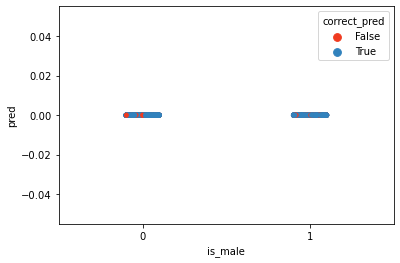

In [149]:
sns.stripplot(data=df_eval,
              x='is_male',
              y='pred',
              hue='correct_pred',
              palette={False: '#f03b20', True: '#3182bd'});

In [150]:
lm_1.predict_proba(df_val[['is_male']])[:5]

array([[0.89331742, 0.10668258],
       [0.80955703, 0.19044297],
       [0.89331742, 0.10668258],
       [0.89331742, 0.10668258],
       [0.80955703, 0.19044297]])

In [151]:
confusion_matrix(df_eval['bank_acc'], df_eval['pred'])

array([[3037,    0],
       [ 492,    0]])


| | predict No account (0) | predict account (1)|
|---|---|---|
| **is no account (0)** | 3037 | 0|
| **is account (1)** | 492 | 0 |

I believe it is predicting all no account because of the following:
* Classes are very imbalanced (85:15 no account to account)
* One variable alone may not be sufficient enough in this instance
* Perhaps because is_male class is also imbalanced?

## Multiple regression
The below analysis is a multiple logistic regression for all features 

__IMPORTANT NOTES__: 
* Investigate adjusting the threshold given how imbalanced the classes are.
* Test feature interactions

In [152]:
features = ['household_size', 'age_of_respondent', 'is_urban', 'cellphone',
       'is_male', 'county_Rwanda', 'county_Tanzania', 'county_Uganda',
       'relationship_with_head_Head of Household',
       'relationship_with_head_Other relative',
       'relationship_with_head_Parent', 'relationship_with_head_Spouse',
       'marital_status_Married/Living together',
       'marital_status_Single/Never Married', 'marital_status_Widowed',
       'education_level_Primary education',
       'education_level_Secondary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_Informally employed', 'job_type_No Income',
       'job_type_Other Income', 'job_type_Remittance Dependent',
       'job_type_Self employed']

scaler = StandardScaler()
x_train1 = scaler.fit_transform(df_train[features])
y_train1 = df_train['bank_acc']

In [153]:
logit_model=sm.Logit(y_train1,x_train1)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.601423
         Iterations 8
                         Results: Logit
Model:              Logit            Pseudo R-squared: -0.480    
Dependent Variable: bank_acc         AIC:              17030.9785
Date:               2021-01-30 11:33 BIC:              17234.9614
No. Observations:   14114            Log-Likelihood:   -8488.5   
Df Model:           26               LL-Null:          -5733.9   
Df Residuals:       14087            LLR p-value:      1.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     8.0000                                       
-------------------------------------------------------------------
           Coef.    Std.Err.      z      P>|z|     [0.025    0.975]
-------------------------------------------------------------------
x1        -0.0068     0.0223   -0.3028   0.7621   -0.0505    0.0370
x2         0.0787     0.0244    3.2231   0.0013    0.0308 

The below analysis includes all features. Thereafter the analyses remove insignificant features one by one.

In [154]:
lm_2 = LogisticRegression()
lm_2.fit(x_train1, y_train1)

x_val1 = scaler.transform(df_val[features])
preds = lm_2.predict(x_val1)
print('Accuracy of logistic regression classifier on val set: {:.2f}'.format(lm_2.score(x_val1, y_val)))

Accuracy of logistic regression classifier on val set: 0.89


In [155]:
import sys
np.set_printoptions(threshold=sys.maxsize)

In [156]:
y_prob = lm_2.predict_proba(x_val[features])

In [157]:
confusion_matrix(df_val['bank_acc'], 
                 preds)

array([[2958,   79],
       [ 324,  168]])


| | predict No account (0) | predict account (1)|
|---|---|---|
| **is no account (0)** | 2958 | 79|
| **is account (1)** | 324 | 168 |

Need to understand and decide on the __trade off between recall and precision__

Precision is the number of observations predicted positive over the total actual positives. The precision is intuitively the ability of the classifier to not label a sample as positive if it is negative.

The recall is the number of actually positive observations over the number predicted positive. The recall is intuitively the ability of the classifier to find all the positive samples.

In [158]:
from sklearn.metrics import classification_report
print(classification_report(y_val, preds))

              precision    recall  f1-score   support

           0       0.90      0.97      0.94      3037
           1       0.68      0.34      0.45       492

    accuracy                           0.89      3529
   macro avg       0.79      0.66      0.70      3529
weighted avg       0.87      0.89      0.87      3529



In [159]:
df_val['proba_bank'] = lm_2.predict_proba(df_val[['household_size', 'age_of_respondent', 'is_urban', 'cellphone',
       'is_male', 'county_Rwanda', 'county_Tanzania', 'county_Uganda',
       'relationship_with_head_Head of Household',
       'relationship_with_head_Other relative',
       'relationship_with_head_Parent', 'relationship_with_head_Spouse',
       'marital_status_Married/Living together',
       'marital_status_Single/Never Married', 'marital_status_Widowed',
       'education_level_Primary education',
       'education_level_Secondary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_Informally employed', 'job_type_No Income',
       'job_type_Other Income', 'job_type_Remittance Dependent',
       'job_type_Self employed']])[:, 1]

fpr, tpr, thresholds = roc_curve(df_val['bank_acc'],
                                 df_val['proba_bank'])

In [160]:
def plot_roc(true, probas):
    auc = roc_auc_score(true, probas)

    plt.plot(fpr, tpr, marker='o')
    plt.xlabel('1 - Specificity (FPR)')
    plt.ylabel('Sensitivity (TPR)');
    plt.title(f"Area Under the ROC Curve: {round(auc, 3)}");

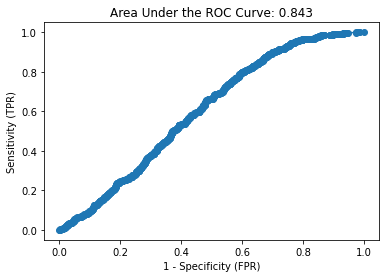

In [161]:
plot_roc(df_val['bank_acc'], lm_2.predict_proba(x_val1)[:, 1]) # new Y's would go here

## Adjusting threshold

In [162]:
threshold = .20
y_pred = np.where((y_prob[:, 0] > threshold),1,0)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [163]:
confusion_matrix(df_val['bank_acc'], 
                 y_pred)

array([[2981,   56],
       [ 492,    0]])

Something is not right in the above, I am clearly referring to the wrong items. The adjusted threshold analysis is worse than with a 50-50 threshold

## Multiple regression removing insignificant features one by one

## Removing household size

Based on logit summary above

In [164]:
x_train_3 = df_train.drop(columns = ['year', 'household_size'])

df_val_3 = df_val.drop(columns = ['year', 'household_size'])

In [165]:
features3 = ['age_of_respondent', 'is_urban', 'cellphone',
       'is_male', 'county_Rwanda', 'county_Tanzania', 'county_Uganda',
       'relationship_with_head_Head of Household',
       'relationship_with_head_Other relative',
       'relationship_with_head_Parent', 'relationship_with_head_Spouse',
       'marital_status_Married/Living together',
       'marital_status_Single/Never Married', 'marital_status_Widowed',
       'education_level_Primary education',
       'education_level_Secondary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_Informally employed', 'job_type_No Income',
       'job_type_Other Income', 'job_type_Remittance Dependent',
       'job_type_Self employed']

In [166]:
scaler3 = StandardScaler()
x_train3 = scaler3.fit_transform(x_train_3[features3])
y_train3 = df_train['bank_acc']

In [167]:
logit_model3=sm.Logit(y_train3,x_train3)
result=logit_model3.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.601427
         Iterations 8
                         Results: Logit
Model:              Logit            Pseudo R-squared: -0.480    
Dependent Variable: bank_acc         AIC:              17029.0702
Date:               2021-01-30 11:33 BIC:              17225.4982
No. Observations:   14114            Log-Likelihood:   -8488.5   
Df Model:           25               LL-Null:          -5733.9   
Df Residuals:       14088            LLR p-value:      1.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     8.0000                                       
-------------------------------------------------------------------
           Coef.    Std.Err.      z      P>|z|     [0.025    0.975]
-------------------------------------------------------------------
x1         0.0786     0.0244    3.2196   0.0013    0.0308    0.1265
x2         0.1038     0.0224    4.6388   0.0000    0.0600 

In [168]:
lm_3 = LogisticRegression()
lm_3.fit(x_train3, y_train3)

x_val3 = scaler3.transform(df_val_3[features3])
preds3 = lm_3.predict(x_val3)
print('Accuracy of logistic regression classifier on val set: {:.2f}'.format(lm_3.score(x_val3, y_val)))

Accuracy of logistic regression classifier on val set: 0.89


In [169]:
confusion_matrix(df_val['bank_acc'], 
                 preds3)

array([[2958,   79],
       [ 325,  167]])

Essentially no change in precision and recall when household size is removed

In [170]:
print(classification_report(y_val, preds3))

              precision    recall  f1-score   support

           0       0.90      0.97      0.94      3037
           1       0.68      0.34      0.45       492

    accuracy                           0.89      3529
   macro avg       0.79      0.66      0.69      3529
weighted avg       0.87      0.89      0.87      3529



## Removing relationship with head - Other 

Based on logit summary above. Note each iteration is building off the previous

In [171]:
x_train_4 = df_train.drop(columns = ['year', 'household_size','relationship_with_head_Other relative'])

df_val_4 = df_val.drop(columns = ['year', 'household_size','relationship_with_head_Other relative'])

In [172]:
features4 = ['age_of_respondent', 'is_urban', 'cellphone',
       'is_male', 'county_Rwanda', 'county_Tanzania', 'county_Uganda',
       'relationship_with_head_Head of Household',
       'relationship_with_head_Parent', 'relationship_with_head_Spouse',
       'marital_status_Married/Living together',
       'marital_status_Single/Never Married', 'marital_status_Widowed',
       'education_level_Primary education',
       'education_level_Secondary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_Informally employed', 'job_type_No Income',
       'job_type_Other Income', 'job_type_Remittance Dependent',
       'job_type_Self employed']

In [173]:
scaler4 = StandardScaler()
x_train4 = scaler4.fit_transform(x_train_4[features4])
y_train4 = df_train['bank_acc']

In [174]:
logit_model4=sm.Logit(y_train4,x_train4)
result=logit_model4.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.601430
         Iterations 8
                         Results: Logit
Model:              Logit            Pseudo R-squared: -0.480    
Dependent Variable: bank_acc         AIC:              17027.1788
Date:               2021-01-30 11:33 BIC:              17216.0519
No. Observations:   14114            Log-Likelihood:   -8488.6   
Df Model:           24               LL-Null:          -5733.9   
Df Residuals:       14089            LLR p-value:      1.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     8.0000                                       
-------------------------------------------------------------------
           Coef.    Std.Err.      z      P>|z|     [0.025    0.975]
-------------------------------------------------------------------
x1         0.0785     0.0244    3.2140   0.0013    0.0306    0.1263
x2         0.1035     0.0224    4.6290   0.0000    0.0597 

In [175]:
lm_4 = LogisticRegression()
lm_4.fit(x_train4, y_train4)

x_val4 = scaler4.transform(df_val_4[features4])
preds4 = lm_4.predict(x_val4)
print('Accuracy of logistic regression classifier on val set: {:.2f}'.format(lm_4.score(x_val4, y_val)))

Accuracy of logistic regression classifier on val set: 0.89


In [176]:
confusion_matrix(df_val['bank_acc'], 
                 preds4)

array([[2959,   78],
       [ 324,  168]])

Minor (1) improvement in predictions for both account and non-account holders

In [177]:
print(classification_report(y_val, preds4))

              precision    recall  f1-score   support

           0       0.90      0.97      0.94      3037
           1       0.68      0.34      0.46       492

    accuracy                           0.89      3529
   macro avg       0.79      0.66      0.70      3529
weighted avg       0.87      0.89      0.87      3529



## Removing relationship with head - Parent 

Based on logit summary above

In [178]:
x_train_5 = df_train.drop(columns = ['year', 'household_size','relationship_with_head_Other relative',
                                     'relationship_with_head_Parent'])

df_val_5 = df_val.drop(columns = ['year', 'household_size','relationship_with_head_Other relative',
                                  'relationship_with_head_Parent'])

features5 = ['age_of_respondent', 'is_urban', 'cellphone',
       'is_male', 'county_Rwanda', 'county_Tanzania', 'county_Uganda',
       'relationship_with_head_Head of Household',
       'relationship_with_head_Spouse',
       'marital_status_Married/Living together',
       'marital_status_Single/Never Married', 'marital_status_Widowed',
       'education_level_Primary education',
       'education_level_Secondary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_Informally employed', 'job_type_No Income',
       'job_type_Other Income', 'job_type_Remittance Dependent',
       'job_type_Self employed']

In [179]:
scaler5 = StandardScaler()
x_train5 = scaler5.fit_transform(x_train_5[features5])
y_train5 = df_train['bank_acc']

In [180]:
logit_model5=sm.Logit(y_train5,x_train5)
result=logit_model5.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.601452
         Iterations 8
                         Results: Logit
Model:              Logit            Pseudo R-squared: -0.480    
Dependent Variable: bank_acc         AIC:              17025.7733
Date:               2021-01-30 11:33 BIC:              17207.0914
No. Observations:   14114            Log-Likelihood:   -8488.9   
Df Model:           23               LL-Null:          -5733.9   
Df Residuals:       14090            LLR p-value:      1.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     8.0000                                       
-------------------------------------------------------------------
           Coef.    Std.Err.      z      P>|z|     [0.025    0.975]
-------------------------------------------------------------------
x1         0.0783     0.0244    3.2091   0.0013    0.0305    0.1262
x2         0.1042     0.0223    4.6670   0.0000    0.0605 

In [181]:
lm_5 = LogisticRegression()
lm_5.fit(x_train5, y_train5)

x_val5 = scaler5.transform(df_val_5[features5])
preds5 = lm_5.predict(x_val5)
print('Accuracy of logistic regression classifier on val set: {:.2f}'.format(lm_5.score(x_val5, y_val)))

Accuracy of logistic regression classifier on val set: 0.89


In [182]:
confusion_matrix(df_val['bank_acc'], 
                 preds5)

array([[2959,   78],
       [ 324,  168]])

No change from the results above

In [183]:
print(classification_report(y_val, preds5))

              precision    recall  f1-score   support

           0       0.90      0.97      0.94      3037
           1       0.68      0.34      0.46       492

    accuracy                           0.89      3529
   macro avg       0.79      0.66      0.70      3529
weighted avg       0.87      0.89      0.87      3529



## Removing marital status - widowed

Based on logit summary above

In [184]:
x_train_6 = df_train.drop(columns = ['year', 'household_size','relationship_with_head_Other relative',
                                     'relationship_with_head_Parent','marital_status_Widowed'])

df_val_6 = df_val.drop(columns = ['year', 'household_size','relationship_with_head_Other relative',
                                  'relationship_with_head_Parent','marital_status_Widowed'])

features6 = ['age_of_respondent', 'is_urban', 'cellphone',
       'is_male', 'county_Rwanda', 'county_Tanzania', 'county_Uganda',
       'relationship_with_head_Head of Household',
       'relationship_with_head_Spouse',
       'marital_status_Married/Living together',
       'marital_status_Single/Never Married',
       'education_level_Primary education',
       'education_level_Secondary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_Informally employed', 'job_type_No Income',
       'job_type_Other Income', 'job_type_Remittance Dependent',
       'job_type_Self employed']

In [185]:
scaler6 = StandardScaler()
x_train6 = scaler6.fit_transform(x_train_6[features6])
y_train6 = df_train['bank_acc']

In [186]:
logit_model6=sm.Logit(y_train6,x_train6)
result6=logit_model6.fit()
print(result6.summary2())

Optimization terminated successfully.
         Current function value: 0.601463
         Iterations 8
                         Results: Logit
Model:              Logit            Pseudo R-squared: -0.481    
Dependent Variable: bank_acc         AIC:              17024.0854
Date:               2021-01-30 11:33 BIC:              17197.8486
No. Observations:   14114            Log-Likelihood:   -8489.0   
Df Model:           22               LL-Null:          -5733.9   
Df Residuals:       14091            LLR p-value:      1.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     8.0000                                       
-------------------------------------------------------------------
           Coef.    Std.Err.      z      P>|z|     [0.025    0.975]
-------------------------------------------------------------------
x1         0.0821     0.0234    3.5024   0.0005    0.0362    0.1281
x2         0.1044     0.0223    4.6753   0.0000    0.0606 

In [187]:
lm_6 = LogisticRegression()
lm_6.fit(x_train6, y_train6)

x_val6 = scaler6.transform(df_val_6[features6])
preds6 = lm_6.predict(x_val6)
print('Accuracy of logistic regression classifier on val set: {:.2f}'.format(lm_6.score(x_val6, y_val)))

Accuracy of logistic regression classifier on val set: 0.89


In [188]:
confusion_matrix(df_val['bank_acc'], 
                 preds6)

array([[2959,   78],
       [ 323,  169]])

Minor (1) improvement in prediction of account holders with the removal of widows

In [189]:
print(classification_report(y_val, preds6))

              precision    recall  f1-score   support

           0       0.90      0.97      0.94      3037
           1       0.68      0.34      0.46       492

    accuracy                           0.89      3529
   macro avg       0.79      0.66      0.70      3529
weighted avg       0.87      0.89      0.87      3529



## Removing remittance / no income 

Based on logit summary above. HOWEVER, consider merging these two and adding as a new column

In [190]:
x_train_7 = df_train.drop(columns = ['year', 'household_size','relationship_with_head_Other relative',
                                     'relationship_with_head_Parent','marital_status_Widowed',
                                    'job_type_Remittance Dependent', 'job_type_No Income'])

df_val_7 = df_val.drop(columns = ['year', 'household_size','relationship_with_head_Other relative',
                                  'relationship_with_head_Parent','marital_status_Widowed',
                                 'job_type_Remittance Dependent','job_type_No Income'])

features7 = ['age_of_respondent', 'is_urban', 'cellphone',
       'is_male', 'county_Rwanda', 'county_Tanzania', 'county_Uganda',
       'relationship_with_head_Head of Household',
       'relationship_with_head_Spouse',
       'marital_status_Married/Living together',
       'marital_status_Single/Never Married',
       'education_level_Primary education',
       'education_level_Secondary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_Informally employed',
       'job_type_Other Income',
       'job_type_Self employed']

In [191]:
scaler7 = StandardScaler()
x_train7 = scaler7.fit_transform(x_train_7[features7])
y_train7 = df_train['bank_acc']

In [192]:
logit_model7=sm.Logit(y_train7,x_train7)
result7=logit_model7.fit()
print(result7.summary2())

Optimization terminated successfully.
         Current function value: 0.601623
         Iterations 8
                         Results: Logit
Model:              Logit            Pseudo R-squared: -0.481    
Dependent Variable: bank_acc         AIC:              17024.6108
Date:               2021-01-30 11:33 BIC:              17183.2642
No. Observations:   14114            Log-Likelihood:   -8491.3   
Df Model:           20               LL-Null:          -5733.9   
Df Residuals:       14093            LLR p-value:      1.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     8.0000                                       
-------------------------------------------------------------------
           Coef.    Std.Err.      z      P>|z|     [0.025    0.975]
-------------------------------------------------------------------
x1         0.0821     0.0234    3.5057   0.0005    0.0362    0.1280
x2         0.1020     0.0221    4.6185   0.0000    0.0587 

Note that Government dependent has now become a signficant feature

In [193]:
lm_7 = LogisticRegression()
lm_7.fit(x_train7, y_train7)

x_val7 = scaler7.transform(df_val_7[features7])
preds7 = lm_7.predict(x_val7)
print('Accuracy of logistic regression classifier on val set: {:.2f}'.format(lm_7.score(x_val7, y_val)))

Accuracy of logistic regression classifier on val set: 0.89


In [194]:
confusion_matrix(df_val['bank_acc'], 
                 preds7)

array([[2959,   78],
       [ 324,  168]])

Minor (1) drop in prediction of account holders with removal of remittance dependent / no income

In [195]:
print(classification_report(y_val, preds7))

              precision    recall  f1-score   support

           0       0.90      0.97      0.94      3037
           1       0.68      0.34      0.46       492

    accuracy                           0.89      3529
   macro avg       0.79      0.66      0.70      3529
weighted avg       0.87      0.89      0.87      3529



## Removing informally employed

Based on logit summary above

In [196]:
x_train_8 = df_train.drop(columns = ['year', 'household_size','relationship_with_head_Other relative',
                                     'relationship_with_head_Parent','marital_status_Widowed',
                                    'job_type_Remittance Dependent', 'job_type_No Income',
                                     'job_type_Informally employed'])

df_val_8 = df_val.drop(columns = ['year', 'household_size','relationship_with_head_Other relative',
                                  'relationship_with_head_Parent','marital_status_Widowed',
                                 'job_type_Remittance Dependent','job_type_No Income',
                                 'job_type_Informally employed'])

features8 = ['age_of_respondent', 'is_urban', 'cellphone',
       'is_male', 'county_Rwanda', 'county_Tanzania', 'county_Uganda',
       'relationship_with_head_Head of Household',
       'relationship_with_head_Spouse',
       'marital_status_Married/Living together',
       'marital_status_Single/Never Married',
       'education_level_Primary education',
       'education_level_Secondary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_Other Income',
       'job_type_Self employed']

In [197]:
scaler8 = StandardScaler()
x_train8 = scaler8.fit_transform(x_train_8[features8])
y_train8 = df_train['bank_acc']

In [198]:
logit_model8=sm.Logit(y_train8,x_train8)
result8=logit_model8.fit()
print(result8.summary2())

Optimization terminated successfully.
         Current function value: 0.601707
         Iterations 8
                         Results: Logit
Model:              Logit            Pseudo R-squared: -0.481    
Dependent Variable: bank_acc         AIC:              17024.9873
Date:               2021-01-30 11:33 BIC:              17176.0858
No. Observations:   14114            Log-Likelihood:   -8492.5   
Df Model:           19               LL-Null:          -5733.9   
Df Residuals:       14094            LLR p-value:      1.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     8.0000                                       
-------------------------------------------------------------------
           Coef.    Std.Err.      z      P>|z|     [0.025    0.975]
-------------------------------------------------------------------
x1         0.0877     0.0231    3.7936   0.0001    0.0424    0.1331
x2         0.0995     0.0220    4.5203   0.0000    0.0564 

In [199]:
lm_8 = LogisticRegression()
lm_8.fit(x_train8, y_train8)

x_val8 = scaler8.transform(df_val_8[features8])
preds8 = lm_8.predict(x_val8)
print('Accuracy of logistic regression classifier on val set: {:.2f}'.format(lm_8.score(x_val8, y_val)))

Accuracy of logistic regression classifier on val set: 0.89


In [200]:
confusion_matrix(df_val['bank_acc'], 
                 preds8)

array([[2961,   76],
       [ 326,  166]])

Minor improvement in recall for non-account but decrease in recall for account

In [201]:
print(classification_report(y_val, preds8))

              precision    recall  f1-score   support

           0       0.90      0.97      0.94      3037
           1       0.69      0.34      0.45       492

    accuracy                           0.89      3529
   macro avg       0.79      0.66      0.69      3529
weighted avg       0.87      0.89      0.87      3529



## Removing Single/Never married

Based on logit summary above

In [202]:
x_train_9 = df_train.drop(columns = ['year', 'household_size','relationship_with_head_Other relative',
                                     'relationship_with_head_Parent','marital_status_Widowed',
                                    'job_type_Remittance Dependent', 'job_type_No Income',
                                     'job_type_Informally employed','marital_status_Single/Never Married'])

df_val_9 = df_val.drop(columns = ['year', 'household_size','relationship_with_head_Other relative',
                                  'relationship_with_head_Parent','marital_status_Widowed',
                                 'job_type_Remittance Dependent','job_type_No Income',
                                 'job_type_Informally employed','marital_status_Single/Never Married'])

features9 = ['age_of_respondent', 'is_urban', 'cellphone',
       'is_male', 'county_Rwanda', 'county_Tanzania', 'county_Uganda',
       'relationship_with_head_Head of Household',
       'relationship_with_head_Spouse',
       'marital_status_Married/Living together',
       'education_level_Primary education',
       'education_level_Secondary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_Other Income',
       'job_type_Self employed']

In [203]:
scaler9 = StandardScaler()
x_train9 = scaler9.fit_transform(x_train_9[features9])
y_train9 = df_train['bank_acc']

In [204]:
logit_model9=sm.Logit(y_train9,x_train9)
result9=logit_model9.fit()
print(result9.summary2())

Optimization terminated successfully.
         Current function value: 0.601714
         Iterations 8
                         Results: Logit
Model:              Logit            Pseudo R-squared: -0.481    
Dependent Variable: bank_acc         AIC:              17023.1773
Date:               2021-01-30 11:33 BIC:              17166.7208
No. Observations:   14114            Log-Likelihood:   -8492.6   
Df Model:           18               LL-Null:          -5733.9   
Df Residuals:       14095            LLR p-value:      1.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     8.0000                                       
-------------------------------------------------------------------
           Coef.    Std.Err.      z      P>|z|     [0.025    0.975]
-------------------------------------------------------------------
x1         0.0899     0.0226    3.9815   0.0001    0.0456    0.1342
x2         0.0987     0.0219    4.4994   0.0000    0.0557 

In [205]:
lm_9 = LogisticRegression()
lm_9.fit(x_train9, y_train9)

x_val9 = scaler9.transform(df_val_9[features9])
preds9 = lm_9.predict(x_val9)
print('Accuracy of logistic regression classifier on val set: {:.2f}'.format(lm_9.score(x_val9, y_val)))

Accuracy of logistic regression classifier on val set: 0.89


In [206]:
confusion_matrix(df_val['bank_acc'], 
                 preds9)

array([[2961,   76],
       [ 325,  167]])

No change in recall for non-account but minor improvement in recall for account

In [207]:
print(classification_report(y_val, preds9))

              precision    recall  f1-score   support

           0       0.90      0.97      0.94      3037
           1       0.69      0.34      0.45       492

    accuracy                           0.89      3529
   macro avg       0.79      0.66      0.70      3529
weighted avg       0.87      0.89      0.87      3529



## Adding female head hh interaction

In [208]:
x_train_10 = x_train_9.copy()
df_val_10 = df_val_9.copy()

x_train_10['female_hh'] = np.where((x_train_10['is_male'] == 0) & 
                                   (x_train_10['relationship_with_head_Head of Household']==1),
                                  1,0)

df_val_10['female_hh'] = np.where((df_val_10['is_male'] == 0) & (df_val_10['relationship_with_head_Head of Household']==1),
                                  1,0)

features10 = ['age_of_respondent', 'is_urban', 'cellphone',
       'is_male', 'county_Rwanda', 'county_Tanzania', 'county_Uganda',
       'relationship_with_head_Head of Household',
       'relationship_with_head_Spouse',
       'marital_status_Married/Living together',
       'education_level_Primary education',
       'education_level_Secondary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_Other Income',
       'job_type_Self employed','female_hh']

In [209]:
scaler10 = StandardScaler()
x_train10 = scaler10.fit_transform(x_train_10[features10])
y_train10 = df_train['bank_acc']

In [210]:
logit_model10=sm.Logit(y_train10,x_train10)
result10=logit_model10.fit()
print(result10.summary2())

Optimization terminated successfully.
         Current function value: 0.601569
         Iterations 8
                         Results: Logit
Model:              Logit            Pseudo R-squared: -0.481    
Dependent Variable: bank_acc         AIC:              17021.0991
Date:               2021-01-30 11:33 BIC:              17172.1975
No. Observations:   14114            Log-Likelihood:   -8490.5   
Df Model:           19               LL-Null:          -5733.9   
Df Residuals:       14094            LLR p-value:      1.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     8.0000                                       
-------------------------------------------------------------------
          Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
-------------------------------------------------------------------
x1        0.0906     0.0226     4.0113   0.0001    0.0463    0.1349
x2        0.0978     0.0219     4.4561   0.0000    0.0548 

In [211]:
lm_10 = LogisticRegression()
lm_10.fit(x_train10, y_train10)

x_val10 = scaler10.transform(df_val_10[features10])
preds10 = lm_10.predict(x_val10)
print('Accuracy of logistic regression classifier on val set: {:.2f}'.format(lm_10.score(x_val10, y_val)))

Accuracy of logistic regression classifier on val set: 0.89


In [212]:
confusion_matrix(df_val['bank_acc'], 
                 preds10)

array([[2962,   75],
       [ 326,  166]])

In [213]:
print(classification_report(y_val, preds10))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      3037
           1       0.69      0.34      0.45       492

    accuracy                           0.89      3529
   macro avg       0.79      0.66      0.69      3529
weighted avg       0.87      0.89      0.87      3529



In [214]:
df_val_10['proba_bank'] = lm_10.predict_proba(df_val_10[['age_of_respondent', 'is_urban', 'cellphone',
       'is_male', 'county_Rwanda', 'county_Tanzania', 'county_Uganda',
       'relationship_with_head_Head of Household',
       'relationship_with_head_Spouse',
       'marital_status_Married/Living together',
       'education_level_Primary education',
       'education_level_Secondary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_Other Income',
       'job_type_Self employed','female_hh']])[:, 1]

fpr10, tpr10, thresholds10 = roc_curve(df_val_10['bank_acc'],
                                 df_val_10['proba_bank'])

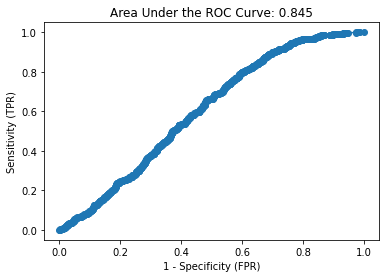

In [215]:
plot_roc(df_val_10['bank_acc'], lm_10.predict_proba(x_val10)[:, 1])

## Adding rural and primary education interaction

In [216]:
x_train_11 = x_train_10.copy()
df_val_11 = df_val_10.copy()

x_train_11['rural_primary'] = np.where((x_train_11['is_urban'] == 0) & 
                                   (x_train_11['education_level_Primary education']==1),
                                  1,0)

df_val_11['rural_primary'] = np.where((df_val_11['is_urban'] == 0) & (df_val_11['education_level_Primary education']==1),
                                  1,0)

features11 = ['age_of_respondent', 'is_urban', 'cellphone',
       'is_male', 'county_Rwanda', 'county_Tanzania', 'county_Uganda',
       'relationship_with_head_Head of Household',
       'relationship_with_head_Spouse',
       'marital_status_Married/Living together',
       'education_level_Primary education',
       'education_level_Secondary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_Other Income',
       'job_type_Self employed','female_hh','rural_primary']

In [217]:
scaler11 = StandardScaler()
x_train11 = scaler11.fit_transform(x_train_11[features11])
y_train11 = df_train['bank_acc']

In [218]:
logit_model11=sm.Logit(y_train11,x_train11)
result11=logit_model11.fit()
print(result11.summary2())

Optimization terminated successfully.
         Current function value: 0.601255
         Iterations 8
                         Results: Logit
Model:              Logit            Pseudo R-squared: -0.480    
Dependent Variable: bank_acc         AIC:              17014.2368
Date:               2021-01-30 11:33 BIC:              17172.8902
No. Observations:   14114            Log-Likelihood:   -8486.1   
Df Model:           20               LL-Null:          -5733.9   
Df Residuals:       14093            LLR p-value:      1.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     8.0000                                       
-------------------------------------------------------------------
           Coef.    Std.Err.      z      P>|z|     [0.025    0.975]
-------------------------------------------------------------------
x1         0.0916     0.0226    4.0544   0.0001    0.0473    0.1358
x2         0.1573     0.0297    5.3036   0.0000    0.0992 

In [219]:
lm_11 = LogisticRegression()
lm_11.fit(x_train11, y_train11)

x_val11 = scaler11.transform(df_val_11[features11])
preds11 = lm_11.predict(x_val11)
print('Accuracy of logistic regression classifier on val set: {:.2f}'.format(lm_11.score(x_val11, y_val)))

Accuracy of logistic regression classifier on val set: 0.89


In [220]:
confusion_matrix(df_val['bank_acc'], 
                 preds11)

array([[2963,   74],
       [ 325,  167]])

In [221]:
print(classification_report(y_val, preds11))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      3037
           1       0.69      0.34      0.46       492

    accuracy                           0.89      3529
   macro avg       0.80      0.66      0.70      3529
weighted avg       0.87      0.89      0.87      3529



## Removing married / living together

In [222]:
x_train_12 = x_train_11.drop(columns='marital_status_Married/Living together')

df_val_12 = df_val_11.drop(columns='marital_status_Married/Living together')

features12 = ['age_of_respondent', 'is_urban', 'cellphone',
       'is_male', 'county_Rwanda', 'county_Tanzania', 'county_Uganda',
       'relationship_with_head_Head of Household',
       'relationship_with_head_Spouse',
       'education_level_Primary education',
       'education_level_Secondary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_Other Income',
       'job_type_Self employed','female_hh','rural_primary']

In [223]:
scaler12 = StandardScaler()
x_train12 = scaler12.fit_transform(x_train_12[features12])
y_train12 = df_train['bank_acc']

In [224]:
logit_model12=sm.Logit(y_train12,x_train12)
result12=logit_model12.fit()
print(result12.summary2())

Optimization terminated successfully.
         Current function value: 0.601299
         Iterations 8
                         Results: Logit
Model:              Logit            Pseudo R-squared: -0.480    
Dependent Variable: bank_acc         AIC:              17013.4704
Date:               2021-01-30 11:33 BIC:              17164.5688
No. Observations:   14114            Log-Likelihood:   -8486.7   
Df Model:           19               LL-Null:          -5733.9   
Df Residuals:       14094            LLR p-value:      1.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     8.0000                                       
-------------------------------------------------------------------
          Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
-------------------------------------------------------------------
x1        0.0909     0.0226     4.0246   0.0001    0.0466    0.1351
x2        0.1565     0.0297     5.2770   0.0000    0.0984 

In [225]:
lm_12 = LogisticRegression()
lm_12.fit(x_train12, y_train12)

x_val12 = scaler12.transform(df_val_12[features12])
preds12 = lm_12.predict(x_val12)
print('Accuracy of logistic regression classifier on val set: {:.2f}'.format(lm_12.score(x_val12, y_val)))

Accuracy of logistic regression classifier on val set: 0.89


In [226]:
confusion_matrix(df_val['bank_acc'], 
                 preds12)

array([[2962,   75],
       [ 324,  168]])

In [227]:
print(classification_report(y_val, preds12))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      3037
           1       0.69      0.34      0.46       492

    accuracy                           0.89      3529
   macro avg       0.80      0.66      0.70      3529
weighted avg       0.87      0.89      0.87      3529



## Removing secondary education

In [228]:
x_train_13 = x_train_12.drop(columns='education_level_Secondary education')

df_val_13 = df_val_12.drop(columns='education_level_Secondary education')

features13 = ['age_of_respondent', 'is_urban', 'cellphone',
       'is_male', 'county_Rwanda', 'county_Tanzania', 'county_Uganda',
       'relationship_with_head_Head of Household',
       'relationship_with_head_Spouse',
       'education_level_Primary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_Other Income',
       'job_type_Self employed','female_hh','rural_primary']

In [229]:
scaler13 = StandardScaler()
x_train13 = scaler13.fit_transform(x_train_13[features13])
y_train13 = df_train['bank_acc']

In [230]:
logit_model13=sm.Logit(y_train13,x_train13)
result13=logit_model13.fit()
print(result13.summary2())

Optimization terminated successfully.
         Current function value: 0.605012
         Iterations 8
                         Results: Logit
Model:              Logit            Pseudo R-squared: -0.489    
Dependent Variable: bank_acc         AIC:              17116.2881
Date:               2021-01-30 11:33 BIC:              17259.8316
No. Observations:   14114            Log-Likelihood:   -8539.1   
Df Model:           18               LL-Null:          -5733.9   
Df Residuals:       14095            LLR p-value:      1.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     8.0000                                       
-------------------------------------------------------------------
          Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
-------------------------------------------------------------------
x1        0.0332     0.0217     1.5293   0.1262   -0.0094    0.0758
x2        0.1910     0.0292     6.5359   0.0000    0.1337 

In [231]:
lm_13 = LogisticRegression()
lm_13.fit(x_train13, y_train13)

x_val13 = scaler13.transform(df_val_13[features13])
preds13 = lm_13.predict(x_val13)
print('Accuracy of logistic regression classifier on val set: {:.2f}'.format(lm_13.score(x_val13, y_val)))

Accuracy of logistic regression classifier on val set: 0.88


In [232]:
confusion_matrix(df_val['bank_acc'], 
                 preds13)

array([[2963,   74],
       [ 338,  154]])

In [233]:
print(classification_report(y_val, preds13))

              precision    recall  f1-score   support

           0       0.90      0.98      0.93      3037
           1       0.68      0.31      0.43       492

    accuracy                           0.88      3529
   macro avg       0.79      0.64      0.68      3529
weighted avg       0.87      0.88      0.86      3529



Note the model does better at predicting WITH secondary education and therefore I should __not use this model__

## Merging formal employment

In [272]:
x_train_14 = x_train_12.copy()

df_val_14 = df_val_12.copy()

x_train_14['job_type_Formally employed'] = np.where((x_train_14['job_type_Formally employed Government'] == 1) |
                                                    (x_train_14['job_type_Formally employed Private'] == 1),1,0)

df_val_14['job_type_Formally employed'] = np.where((df_val_14['job_type_Formally employed Government'] == 1) |
                                                    (df_val_14['job_type_Formally employed Private'] == 1),1,0)

x_train_14 = x_train_14.drop(columns=['job_type_Formally employed Government','job_type_Formally employed Private'])

df_val_14 = df_val_14.drop(columns=['job_type_Formally employed Government','job_type_Formally employed Private'])


features14 = ['age_of_respondent', 'is_urban', 'cellphone',
       'is_male', 'county_Rwanda', 'county_Tanzania', 'county_Uganda',
       'relationship_with_head_Head of Household',
       'relationship_with_head_Spouse',
       'education_level_Primary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Government Dependent',
       'job_type_Other Income',
       'job_type_Self employed','female_hh','rural_primary','job_type_Formally employed']

In [273]:
scaler14 = StandardScaler()
x_train14 = scaler14.fit_transform(x_train_14[features14])
y_train14 = df_train['bank_acc']

In [274]:
logit_model14=sm.Logit(y_train14,x_train14)
result14=logit_model14.fit()
print(result14.summary2())

Optimization terminated successfully.
         Current function value: 0.620508
         Iterations 7
                         Results: Logit
Model:              Logit            Pseudo R-squared: -0.527    
Dependent Variable: bank_acc         AIC:              17551.7002
Date:               2021-01-30 16:07 BIC:              17687.6888
No. Observations:   14114            Log-Likelihood:   -8757.9   
Df Model:           17               LL-Null:          -5733.9   
Df Residuals:       14096            LLR p-value:      1.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
-------------------------------------------------------------------
          Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
-------------------------------------------------------------------
x1        0.0298     0.0213     1.3994   0.1617   -0.0119    0.0715
x2        0.2071     0.0296     6.9990   0.0000    0.1491 

In [275]:
lm_14 = LogisticRegression()
lm_14.fit(x_train14, y_train14)

x_val14 = scaler14.transform(df_val_14[features14])
preds14 = lm_14.predict(x_val14)
print('Accuracy of logistic regression classifier on val set: {:.2f}'.format(lm_14.score(x_val14, y_val)))

Accuracy of logistic regression classifier on val set: 0.88


In [276]:
confusion_matrix(df_val['bank_acc'], 
                 preds14)

array([[2963,   74],
       [ 338,  154]])

In [277]:
print(classification_report(y_val, preds14))

              precision    recall  f1-score   support

           0       0.90      0.98      0.93      3037
           1       0.68      0.31      0.43       492

    accuracy                           0.88      3529
   macro avg       0.79      0.64      0.68      3529
weighted avg       0.87      0.88      0.86      3529



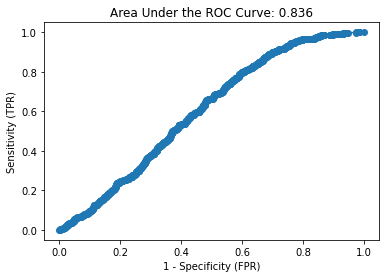

In [278]:
plot_roc(df_val_14['bank_acc'], lm_14.predict_proba(x_val14)[:, 1])

Did not improve the model, therefore, keep formal employment seperated

## Testing the model on the test set

Note the first analysis is based on the first multiple regression model above (including all features, no interactions)

1. Preparing the test sample 

In [234]:
x_test['is_urban'] = np.where(x_test['location_type'] == 'Urban',1,0)
x_test['cellphone'] = np.where(x_test['cellphone_access'] == 'Yes',1,0)
x_test['is_male'] = np.where(x_test['gender_of_respondent'] == 'Male',1,0)

<ipython-input-234-120e2e6065ba>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['is_urban'] = np.where(x_test['location_type'] == 'Urban',1,0)
<ipython-input-234-120e2e6065ba>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['cellphone'] = np.where(x_test['cellphone_access'] == 'Yes',1,0)
<ipython-input-234-120e2e6065ba>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [235]:
x_test_cont = x_test[['year','household_size','age_of_respondent','is_urban','cellphone','is_male']]
x_test_cat = x_test[['country','relationship_with_head', 'marital_status','education_level', 'job_type']]

In [236]:
x_test_cat.loc[x_test_cat['marital_status'] == 'Dont know', ['marital_status']] = 'Single/Never Married'
x_test_cat.loc[x_test_cat['education_level'] == 'Other/Dont know/RTA', ['education_level']] = 'No formal education'
x_test_cat.loc[x_test_cat['job_type'] == 'Dont Know/Refuse to answer', ['job_type']] = 'No Income'
x_test_cat.loc[x_test_cat['relationship_with_head'] == 'Other non-relatives', ['relationship_with_head']] = 'Other relative'

/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-236-c58a8d9a8085>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test_cat.loc[x_test_cat['marital_status'] == 'Dont know', ['marital_status']] = 'Single/Never Married'
<ipython-input-236-c58a8d9a8085>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-vers

In [237]:
ohe = OneHotEncoder(drop='first', sparse=False)

ohe.fit(x_test_cat)

ohe_x_test = ohe.transform(x_test_cat)

columns = ohe.get_feature_names(['county','relationship_with_head', 'marital_status',
       'education_level', 'job_type'])

ohe_x_test_df = pd.DataFrame(ohe_x_test, columns=columns, index=x_test.index)

In [238]:
combo_test_df = pd.concat([x_test_cont, ohe_x_test_df], axis=1)

In [239]:
y_test['bank_acc'] = np.where(y_test['bank_account'] == 'Yes', 1,0)
y_test.drop(columns='bank_account',inplace=True)
df_test = pd.concat([combo_test_df,y_test],axis=1)

<ipython-input-239-52765b19127d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['bank_acc'] = np.where(y_test['bank_account'] == 'Yes', 1,0)
/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


2. Testing the model on the test sample

In [240]:
x_test1 = scaler.transform(df_test[features])
preds1 = lm_2.predict(x_test1)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(lm_2.score(x_test1, y_test)))

Accuracy of logistic regression classifier on test set: 0.88


In [241]:
confusion_matrix(df_test['bank_acc'], 
                 preds1)

array([[4897,  150],
       [ 543,  291]])


| | predict No account (0) | predict account (1)|
|---|---|---|
| **is no account (0)** | 4839 | 149|
| **is account (1)** | 543 | 291 |

Need to do the following:
* Check error metrics
* Conduct cross validation
* Test with other classification models 

In [242]:
print(classification_report(y_test, preds1))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93      5047
           1       0.66      0.35      0.46       834

    accuracy                           0.88      5881
   macro avg       0.78      0.66      0.70      5881
weighted avg       0.87      0.88      0.87      5881



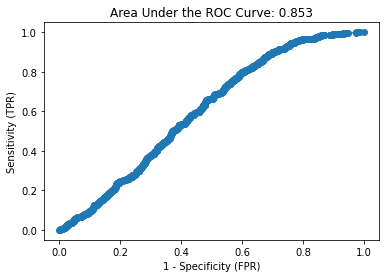

In [243]:
plot_roc(df_test['bank_acc'], lm_2.predict_proba(x_test1)[:, 1])

## Multiple regression with model 12

In [253]:
df_test_12 = df_test.drop(columns= ['year', 'household_size','marital_status_Married/Living together',
                          'relationship_with_head_Other relative',
                          'relationship_with_head_Parent','marital_status_Widowed','job_type_Remittance Dependent',
                         'job_type_No Income'])


df_test_12['female_hh'] = np.where((df_test_12['is_male'] == 0) & 
                                   (df_test_12['relationship_with_head_Head of Household']==1),
                                  1,0)

df_test_12['rural_primary'] = np.where((df_test_12['is_urban'] == 0) & 
                                   (df_test_12['education_level_Primary education']==1),
                                  1,0)

features12 = ['age_of_respondent', 'is_urban', 'cellphone',
       'is_male', 'county_Rwanda', 'county_Tanzania', 'county_Uganda',
       'relationship_with_head_Head of Household',
       'relationship_with_head_Spouse',
       'education_level_Primary education',
       'education_level_Secondary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_Other Income',
       'job_type_Self employed','female_hh','rural_primary']

In [258]:
x_test12 = scaler12.transform(df_test_12[features12])
preds12_test = lm_12.predict(x_test12)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(lm_12.score(x_test12, y_test)))

Accuracy of logistic regression classifier on test set: 0.88


In [259]:
confusion_matrix(df_test_12['bank_acc'], 
                 preds12_test)

array([[4899,  148],
       [ 546,  288]])

In [260]:
print(classification_report(y_test, preds12_test))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93      5047
           1       0.66      0.35      0.45       834

    accuracy                           0.88      5881
   macro avg       0.78      0.66      0.69      5881
weighted avg       0.87      0.88      0.87      5881



Model is broadly consistent across train - val - test